In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time

In [2]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


# Import network, layers and functions

In [3]:
from nnet.network import Sequential
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,BatchNormalization
from nnet import optimizers
from nnet import functions
import numpy as np

Seed: 249
Seed: 272


In [4]:
np.random.seed(102)

# Make Sequential Model

In [5]:
model=Sequential()

In [6]:
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu,input_shape=(32,32,3)))
# model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
model.add(max_pool())
model.add(dropout(0.1))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
# model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
model.add(max_pool())
model.add(dropout(0.2))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
# model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
model.add(max_pool())
model.add(dropout(0.3))
model.add(flatten())
model.add(dense(512,activation=functions.relu))
model.add(BatchNormalization())
model.add(dropout(0.4))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [7]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
input_layer (InputLayer)  (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)           (None, 32, 32, 32)         relu             896
__________________________________________________________________________________________
BatchNormalization (Batch (None, 32, 32, 32)         echo             128
__________________________________________________________________________________________
max_pool (max_pool)       (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
dropout (dropout)         (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
conv2d (conv

# Compile model with optimizer, loss and lr

In [8]:
model.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

# Reload saved model weights

In [9]:
# model.load_weights("cifar.dump")

# Train model

In [10]:
losses=[]
train_acc=[]

In [11]:
def validate(vdsz=128):
    dvme=len(dt.test_images)//vdsz
    acc=0
    cross_entropy_loss=0
    for smpl in range(0,len(dt.test_images),vdsz):
        print("\rCalculating Validation acc...",dvme-smpl//vdsz,end=' ')
        inp = dt.test_images[smpl:smpl+vdsz].reshape(-1,32,32,3)
        y_inp = dt.test_labels[smpl:smpl+vdsz]
        logits=model.predict(inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc+=100*(ans==cor).mean()
        cross_entropy_loss+=model.loss(logits,labels=y_inp).mean()*10
    print("\rValidation Acc: {:.3f} %        Val loss: {:.8f}".format(acc/dvme,cross_entropy_loss/dvme))
    model.free()

In [12]:
def run():
    btsz=128
    acc_tn=0
    loss_tn=0
    pre_tm=0
    itr_train=dt.data_augment(btsz)
    len_itr=len(itr_train)
    for i in range(1,len_itr+1):
        sam_tm=time()
        perc=100*i/len_itr
#         inp,y_inp=dt.batch_gen(btsz)
        inp,y_inp=itr_train.next()
        logits=model.fit(inp,y_inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc=100*(ans==cor).mean()
        cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()*10
        acc_tn+=acc
        loss_tn+=cross_entropy_loss
        acc=acc_tn/i
        loss_=loss_tn/i
        losses.append(loss_)
        train_acc.append(acc)
        if acc>=80:
            model.learning_rate=1e-4/2
        elif acc>=77:
            model.learning_rate=1e-4
        elif acc>=75:
            model.learning_rate=1e-3/2
        sam_tm=time()-sam_tm
        pre_tm+=sam_tm
        sam_tm=pre_tm/i
        rem_sam=(len_itr-i)
        eta=int(rem_sam*sam_tm)
        print("\rProgress: {:.2f} %    Acc: {:.3f} %    loss: {:.6f}     Sample time: {:.3f}s    ETA: {}:{}s    _".format(perc,acc,loss_,sam_tm,eta//60,eta%60),end='')
    print("")

In [18]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 5
Progress: 100.00 %    Acc: 73.919 %    loss: 0.741460     Sample time: 0.958s    ETA: 0:0s    _
Epoch time: 6:15s
Validation Acc: 75.541 %        Val loss: 1.71066976
EPOCH: 2 / 5
Progress: 100.00 %    Acc: 75.286 %    loss: 0.703121     Sample time: 0.975s    ETA: 0:0s    _
Epoch time: 6:22s
Validation Acc: 74.900 %        Val loss: 1.28675045
EPOCH: 3 / 5
Progress: 100.00 %    Acc: 74.211 %    loss: 0.730804     Sample time: 0.967s    ETA: 0:0s    _
Epoch time: 6:18s
Validation Acc: 76.512 %        Val loss: 1.29727809
EPOCH: 4 / 5
Progress: 100.00 %    Acc: 76.016 %    loss: 0.682519     Sample time: 0.932s    ETA: 0:0s    _
Epoch time: 6:5s
Validation Acc: 78.065 %        Val loss: 1.22590948
EPOCH: 5 / 5
Progress: 100.00 %    Acc: 76.525 %    loss: 0.668034     Sample time: 0.986s    ETA: 0:0s    _
Epoch time: 6:26s
Validation Acc: 77.524 %        Val loss: 1.20886765


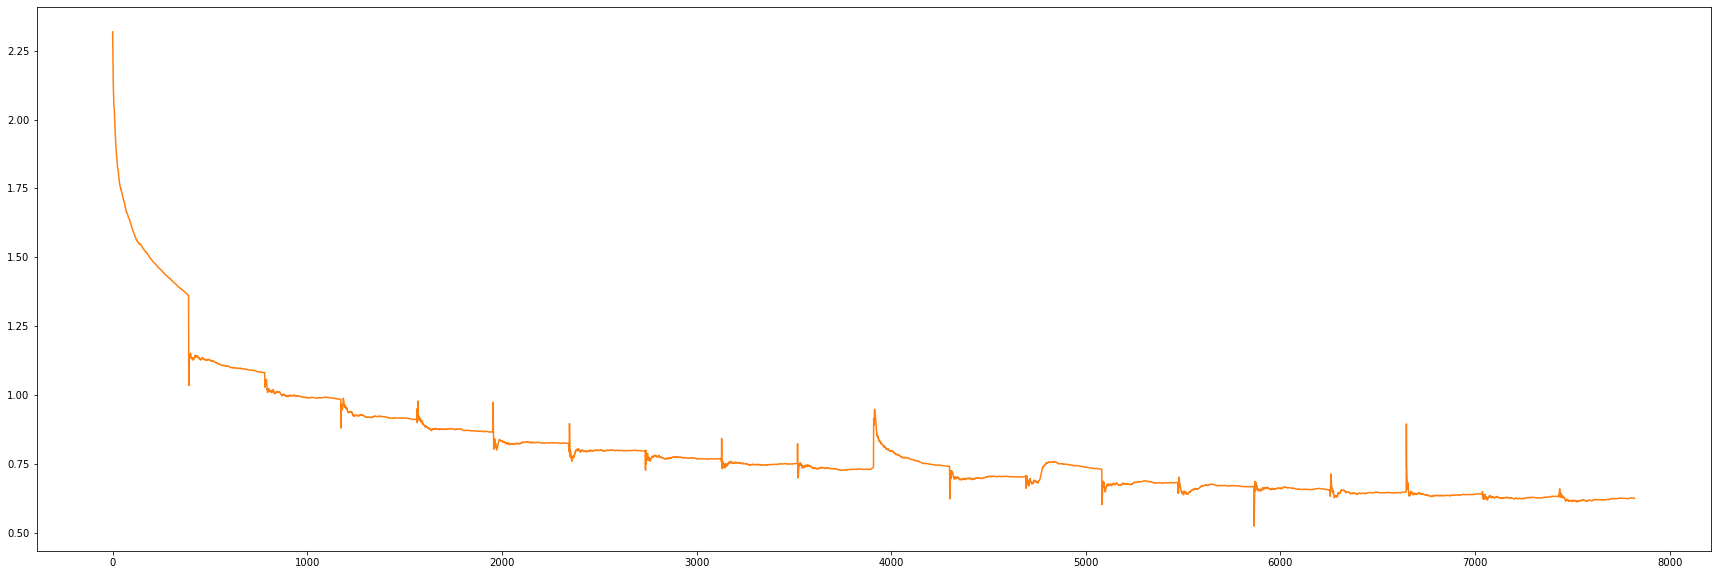

In [21]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

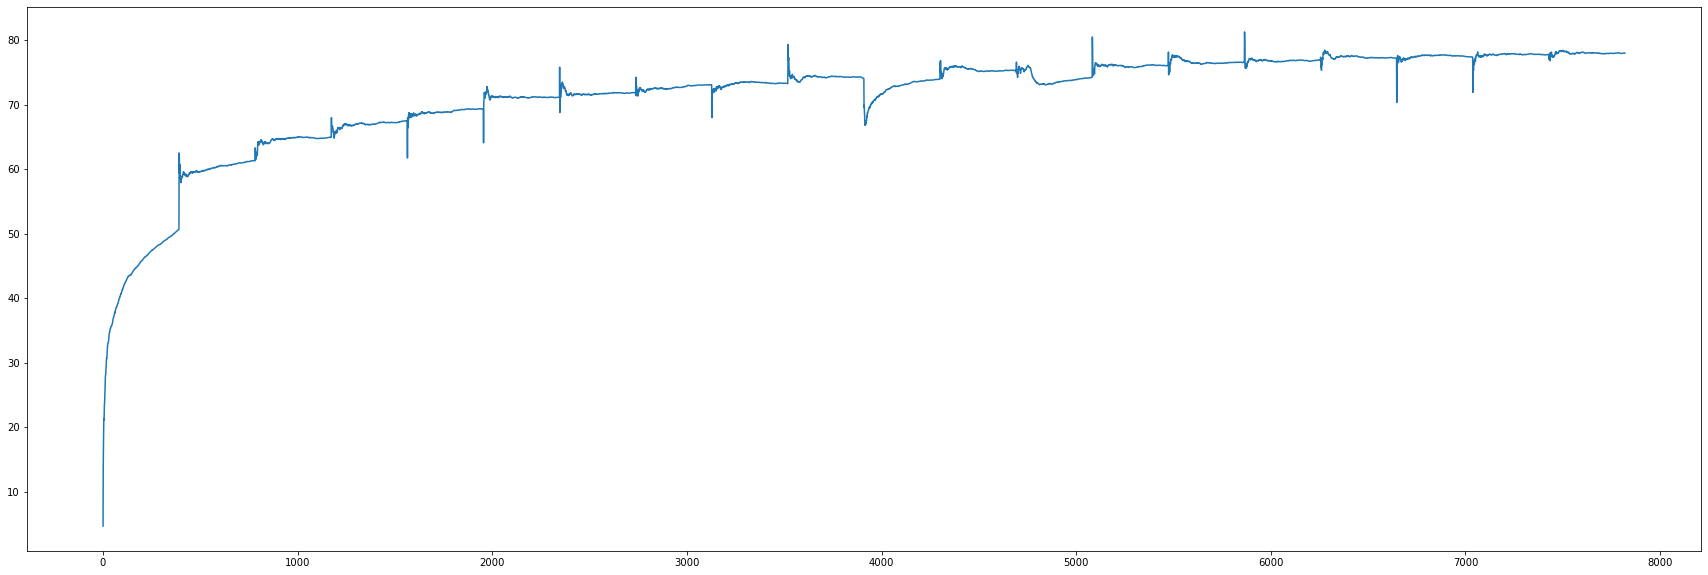

In [22]:
plt.figure(figsize=(30,10))
plt.plot(train_acc)#,color='#ff7f0e')
plt.show()

In [19]:
from gc import collect
collect()

920

In [23]:
model.save_weights("cifar.dump")

Prediction:  airplane 
Correct answer:  airplane


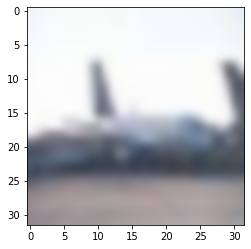

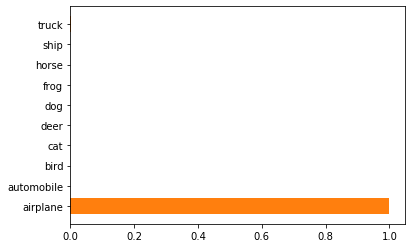

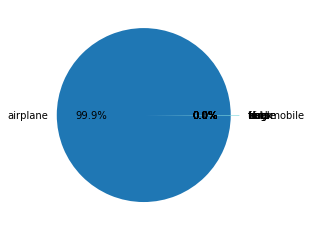

In [26]:
ck=np.random.randint(0,10000)
# inp,y_inp=dt.batch_gen(size=1,ck=ck)
inp = dt.test_images[ck:ck+1].reshape(-1,32,32,3)
y_inp = dt.test_labels[ck:ck+1]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
# plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()

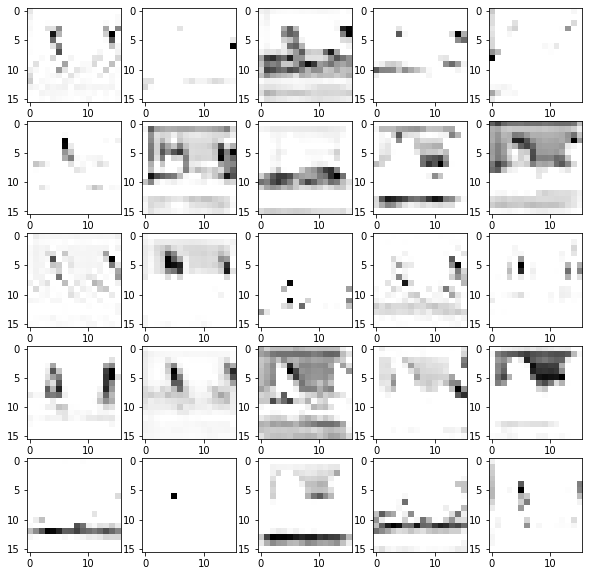

In [27]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[4].z_out[0].transpose(2,0,1)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')

In [145]:
import cv2
import os

Prediction:  dog


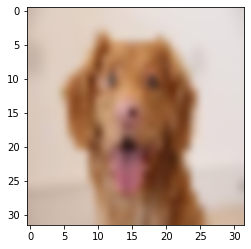

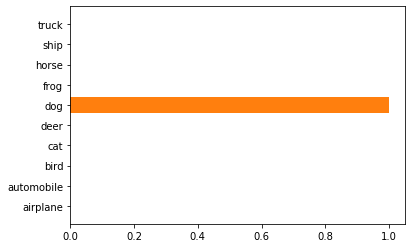

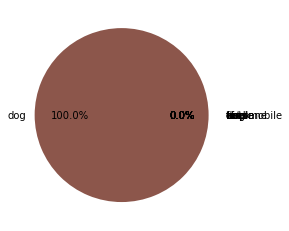

In [182]:
img=cv2.imread("download.jpeg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
inp=cv2.resize(img,(32,32),interpolation=cv2.INTER_CUBIC).reshape(-1,32,32,3)
logits=model.predict(inp)
ans=logits.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
# plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()